In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "7680_med_compress_pcm"
params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 112682
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  _, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  u_vals = u_list[int(params["num_layers"]/2)]
  coord.request_stop()
  coord.join(enqueue_threads)

In [4]:
u_vals = u_list[int(params["num_layers"]/2)].reshape((100, 16*16*128))

In [81]:
def get_line_eq(x_points, y_points):
  m = (y_points[1]-y_points[0]) / (x_points[1]-x_points[0])
  b = y_points[1] - m * x_points[1]
  return (m, b)

In [92]:
def get_differential_entropy(x_points, y_points):
  m, b = get_line_eq(x_points, y_points)
  if m == 0:
    if b == 0:
      return 0
    else:
      return x_points[1]*-(b*np.log(b)) - x_points[0]*-(b*np.log(b))
  else:
    integral = lambda x, m, b: -(2*(m*x+b)**2 * np.log(m*x+b) - m*x*(m*x+2*b))/(4*m)
    return integral(x_points[1], m, b) - integral(x_points[0], m, b)

In [93]:
def unit_entropy(data, eps=None):
  entropy = 0
  for xy_points in data:
    if (xy_points[1][0] == xy_points[1][1] and xy_points[1][1] == 0):
      entropy += 0
    else:
      if eps is not None:
        if xy_points[1][0] == 0:
          xy_points[1][0] += eps
        if xy_points[1][1] == 0:
          xy_points[1][1] += eps
      entropy += get_differential_entropy(xy_points[0], xy_points[1])
  return entropy

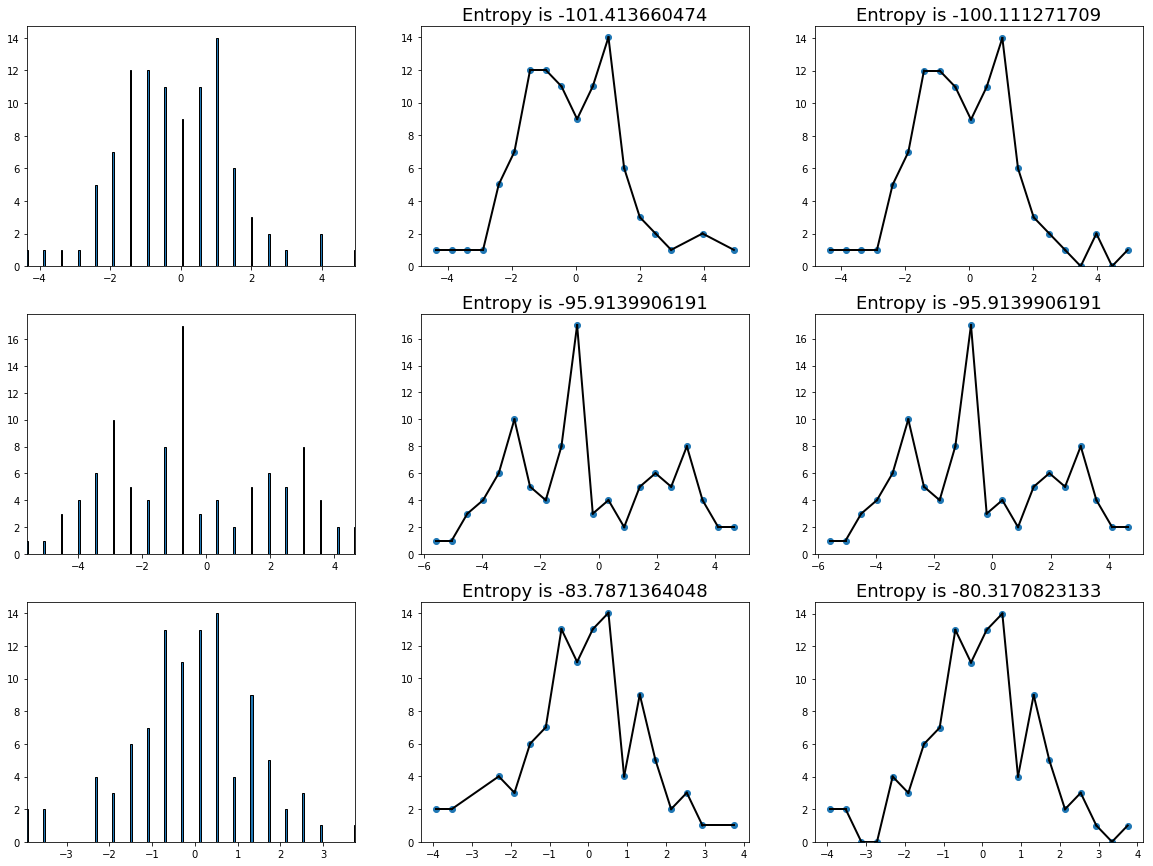

In [94]:
num_plots = 3
num_bins = 20
fig, ax = plt.subplots(num_plots, 3, figsize=(20, 5*num_plots))
for plot in range(num_plots):
    rnd_unit = np.random.choice(16*16*128)
    u_val = u_vals[:, rnd_unit]

    hist, bin_edges = np.histogram(u_val, bins=num_bins)
    bin_edges = bin_edges[:-1]

    ax[plot, 0].bar(bin_edges, hist, edgecolor="k", width=0.05)
    ax[plot, 0].set_xlim((min(bin_edges), max(bin_edges)))

    nz_idx = np.nonzero(hist)[0]
    ax[plot, 1].scatter(bin_edges[nz_idx], hist[nz_idx])
    hist_data = []
    for index in np.arange(len(nz_idx[:-1])):
      start_id = nz_idx[index]
      end_id = nz_idx[index+1]
      x_points = [bin_edges[start_id], bin_edges[end_id]]
      y_points = [hist[start_id], hist[end_id]]
      hist_data.append((x_points, y_points))
      ax[plot, 1].plot(x_points, y_points, linewidth=2, color="k")
    entropy = unit_entropy(hist_data)
    ax[plot, 1].set_title("Entropy is "+str(entropy), fontsize=18)
    ylim = ax[plot, 1].get_ylim()
    ax[plot, 1].set_ylim((0, ylim[1]))
    
    ax[plot, 2].scatter(bin_edges, hist)
    hist_data = []
    for index in np.arange(len(hist[:-1])):
      x_points = [bin_edges[index], bin_edges[index+1]]
      y_points = [hist[index], hist[index+1]]
      #print(y_points)
      hist_data.append((x_points, y_points))
      ax[plot, 2].plot(x_points, y_points, linewidth=2, color="k")
    entropy = unit_entropy(hist_data, eps=1e-12)
    ax[plot, 2].set_title("Entropy is "+str(entropy), fontsize=18)
    ylim = ax[plot, 2].get_ylim()
    ax[plot, 2].set_ylim((0, ylim[1]))
plt.show()


[ 1.92958939 -1.65599477 -1.65599477 -0.18184467 -0.31156304 -0.83882642
  0.62026876 -0.19624671  1.9965421  -0.53854352]
[1, 2, 2, 3, 1, 1, 1, 2, 2, 1]


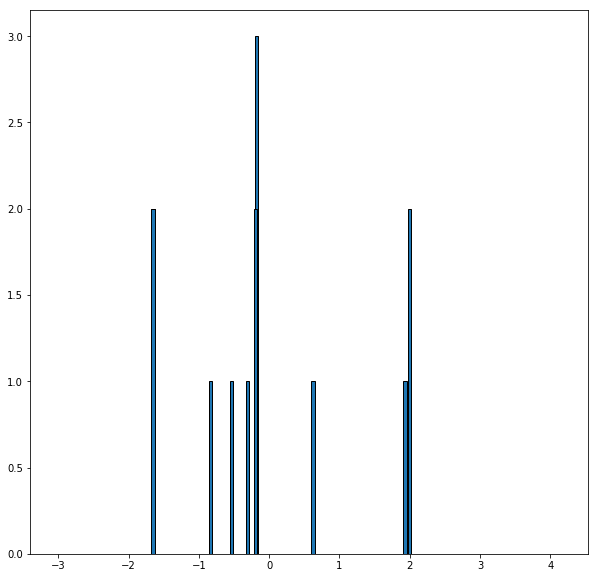

In [73]:
sample_indices = np.random.choice(np.arange(len(u_vals)), 10)
sample_activations = u_val[sample_indices]
print(u_val[sample_indices])

eps = 1e-2

count = lambda x,y,z: np.sum(np.int32((x<y+z) & (x>y-z)))

counts = [count(u_val, u_val[samp], eps) for samp in sample_indices]
print(counts)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.bar(sample_activations, counts, edgecolor="k", width=0.05)
ax.set_xlim((min(bin_edges), max(bin_edges)))
plt.show()